# **Exploratory Data Analysis (EDA) on IMDb Reviews Dataset**

This notebook walks through a **step-by-step EDA** on the IMDb dataset.  
By the end, you will learn:

- How to load and inspect raw text datasets.  
- How to analyze distributions (length, class balance).  
- How to extract meaningful vocabulary & n-grams.  
- How linguistic features differ across sentiments.  
- How to visualize separability of classes.  


In [20]:
# =============================
# 1. Setup & Imports
# =============================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")

sns.set(style="whitegrid", palette="muted", font_scale=1.2)


[nltk_data] Downloading package punkt to /Users/ravina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ravina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ravina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 📥 Load Dataset

We assume the IMDB dataset has been downloaded from [Stanford IMDB Sentiment dataset](https://ai.stanford.edu/~amaas/data/sentiment/) and extracted into the `data/` folder.

The folder structure should look like this:

```
data/
  aclImdb/
    train/
      pos/
      neg/
    test/
      pos/
      neg/
```

In [10]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /Users/ravina/Desktop/text_classification_project/notebooks


In [ ]:
# =============================
# 2. Load Data
# =============================

def load_imdb_dataset(data_dir):
    data = {"review": [], "sentiment": [], "split": []}
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            path = os.path.join(data_dir, split, sentiment)
            for file in os.listdir(path):
                with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                    data["review"].append(f.read())
                    data["sentiment"].append(sentiment)
                    data["split"].append(split)
    return pd.DataFrame(data)

# ✅ path of your dataset folder
data_dir = "../data/aclImdb"
df = load_imdb_dataset(data_dir)

df.head()


,review,sentiment,split
0,For a movie that gets no respect there sure ar...,pos,train
1,Bizarre horror movie filled with famous faces ...,pos,train
2,"A solid, if unremarkable film. Matthau, as Ein...",pos,train
3,It's a strange feeling to sit alone in a theat...,pos,train
4,"You probably all already know this by now, but...",pos,train


## 🔍 Dataset Overview

Shape of dataset: (50000, 3)

Data Types:
review       object
sentiment    object
split        object
dtype: object

Missing Values:
review       0
sentiment    0
split        0
dtype: int64

Class Distribution:
sentiment
pos    25000
neg    25000
Name: count, dtype: int64


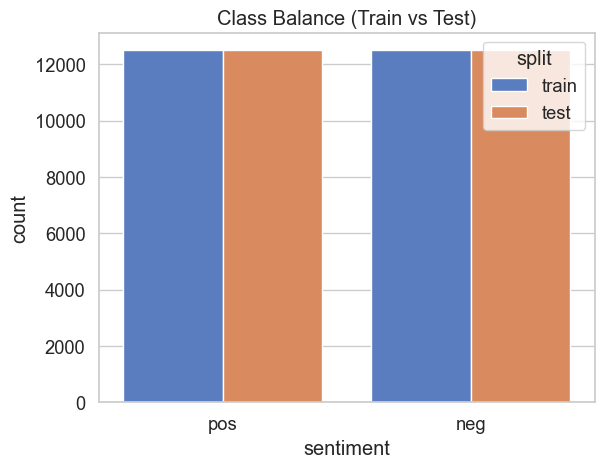

In [22]:
# =============================
# 3. Dataset Overview
# =============================

print("Shape of dataset:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nClass Distribution:")
print(df['sentiment'].value_counts())

sns.countplot(data=df, x="sentiment", hue="split")
plt.title("Class Balance (Train vs Test)")
plt.show()


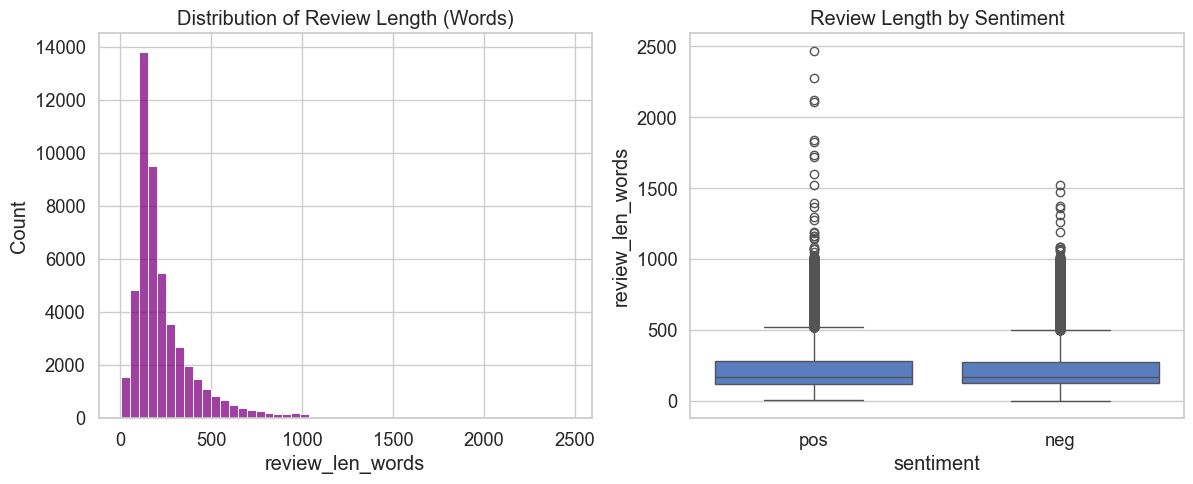

In [23]:
# =============================
# 4. Review Length Analysis
# =============================

df["review_len_words"] = df["review"].apply(lambda x: len(x.split()))
df["review_len_chars"] = df["review"].apply(len)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df["review_len_words"], bins=50, ax=axes[0], color="purple")
axes[0].set_title("Distribution of Review Length (Words)")

sns.boxplot(data=df, x="sentiment", y="review_len_words", ax=axes[1])
axes[1].set_title("Review Length by Sentiment")
plt.show()


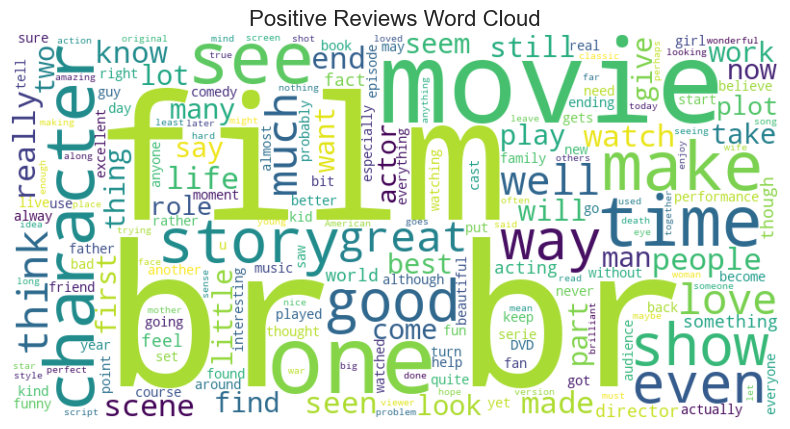

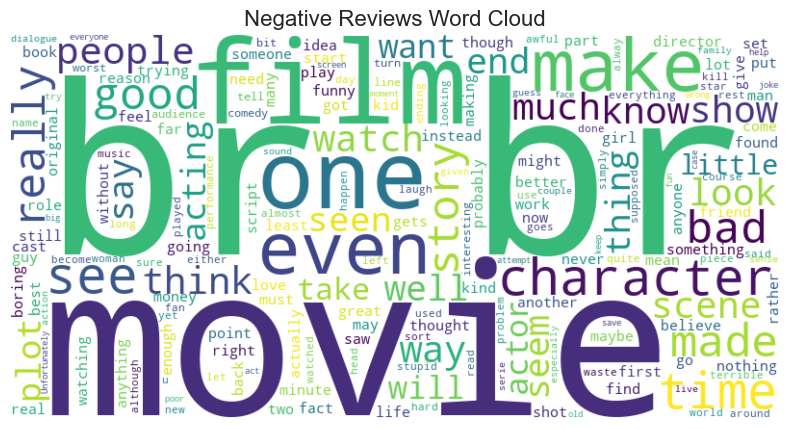

In [24]:
# =============================
# 5. Frequent Words & Word Clouds
# =============================

stop_words = set(stopwords.words("english"))

def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Separate pos/neg reviews
pos_text = df[df["sentiment"]=="pos"]["review"]
neg_text = df[df["sentiment"]=="neg"]["review"]

plot_wordcloud(pos_text, "Positive Reviews Word Cloud")
plot_wordcloud(neg_text, "Negative Reviews Word Cloud")


In [25]:
# =============================
# 6. N-Gram Analysis
# =============================

def get_top_ngrams(corpus, n=None, ngram_range=(1,1)):
    vec = CountVectorizer(stop_words="english", ngram_range=ngram_range).fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

top_unigrams = get_top_ngrams(df["review"], n=20, ngram_range=(1,1))
top_bigrams = get_top_ngrams(df["review"], n=20, ngram_range=(2,2))

print("Top Unigrams:", top_unigrams[:10])
print("Top Bigrams:", top_bigrams[:10])


Top Unigrams: [('br', np.int64(201951)), ('movie', np.int64(87971)), ('film', np.int64(79705)), ('like', np.int64(40172)), ('just', np.int64(35184)), ('good', np.int64(29753)), ('time', np.int64(25110)), ('story', np.int64(23119)), ('really', np.int64(23094)), ('bad', np.int64(18473))]
Top Bigrams: [('br br', np.int64(101188)), ('ve seen', np.int64(4168)), ('br film', np.int64(3007)), ('br movie', np.int64(2992)), ('movie br', np.int64(2358)), ('special effects', np.int64(2249)), ('don know', np.int64(2201)), ('film br', np.int64(2079)), ('low budget', np.int64(1824)), ('looks like', np.int64(1677))]


In [26]:
# =============================
# 7. Chi-Square Feature Importance
# =============================

cv = CountVectorizer(stop_words="english")
X = cv.fit_transform(df["review"])
y = df["sentiment"].map({"neg":0, "pos":1})

chi2_vals, p_vals = chi2(X, y)
feature_names = np.array(cv.get_feature_names_out())

top_pos_idx = np.argsort(chi2_vals)[-20:]
top_neg_idx = np.argsort(chi2_vals)[:20]

print("Top Positive words:", feature_names[top_pos_idx])
print("Top Negative words:", feature_names[top_neg_idx])


Top Positive words: ['supposed' 'crap' 'minutes' 'poor' 'horrible' 'just' 'worse' 'wonderful'
 'love' 'boring' 'best' 'stupid' 'excellent' 'movie' 'terrible' 'waste'
 'awful' 'great' 'worst' 'bad']
Top Negative words: ['belfry' 'picturisations' 'doping' 'carpetbaggers' 'vacuuming' 'pickups'
 'anding' 'pickpocketing' 'dor' 'dora' 'picknick' 'doorways' 'dorama'
 'andersons' 'pickings' 'pickin' 'vagrants' 'vagueness' 'doren' 'trainor']


In [30]:
! pip install spacy

  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.3.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 4.1 MB/s  0:00:01 eta 0:00:01
Using cached catalogue-2.0.10-py3-none-any.whl (17 kB)
Using cached langcodes-3.5.0-py3-none-any.whl (182 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.2 MB/s  

In [32]:
! python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.0 kB/s  0:02:44m0:00:0300:07
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [33]:
import spacy
from collections import Counter
import pandas as pd

# Load spaCy small English model
nlp = spacy.load("en_core_web_sm")

def get_pos_counts_spacy(text):
    doc = nlp(text)
    counts = Counter([token.pos_ for token in doc])
    return counts

# Apply to a sample for speed
sampled_df = df.sample(1000, random_state=42).copy()
sampled_df["pos_counts"] = sampled_df["review"].apply(get_pos_counts_spacy)

# Aggregate POS counts by sentiment
pos_summary = (
    sampled_df.groupby("sentiment")["pos_counts"]
    .apply(lambda x: sum(x, Counter()))
)

pos_summary_df = pd.DataFrame(pos_summary.tolist(), index=pos_summary.index).fillna(0)
pos_summary_df


0
sentiment             
neg       PRON   10985
          AUX     7815
          DET    11748
          ADJ     9114
          NOUN   20228
          ADP    11191
          PROPN   7351
          PART    3844
          PUNCT  15443
          VERB   13094
          ADV     7113
          CCONJ   4143
          NUM     1312
          INTJ     326
          SCONJ   2539
          X        409
          SYM      155
          SPACE     12
pos       PRON   11738
          AUX     7713
          DET    12632
          ADJ    10209
          NOUN   22189
          ADP    12696
          PROPN   9492
          PART    3643
          PUNCT  16354
          VERB   13361
          ADV     7230
          CCONJ   4834
          NUM     1396
          INTJ     252
          SCONJ   2603
          X        452
          SYM      133
          SPACE     37

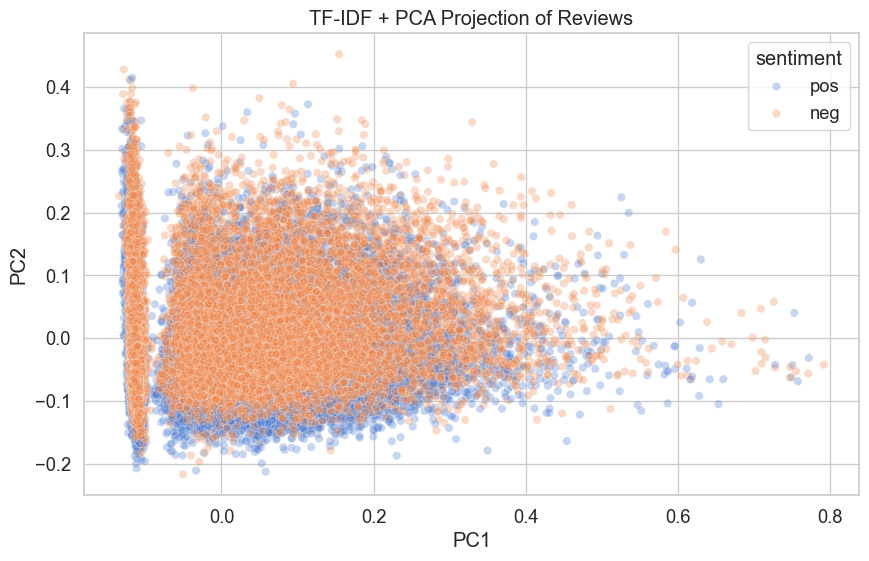

In [28]:
# =============================
# 9. Embedding Visualization (TF-IDF + PCA)
# =============================

from sklearn.decomposition import PCA

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf.fit_transform(df["review"])

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_plot["sentiment"] = df["sentiment"]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="sentiment", alpha=0.3)
plt.title("TF-IDF + PCA Projection of Reviews")
plt.show()


## 🧹 Text Preprocessing

We will:
- Lowercase text
- Remove HTML tags
- Remove punctuation
- Remove stopwords


In [17]:

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing on sample
df['clean_review'] = df['review'].apply(clean_text)
df[['review','clean_review']].head()


,review,clean_review
0,For a movie that gets no respect there sure ar...,movie gets respect sure lot memorable quotes l...
1,Bizarre horror movie filled with famous faces ...,bizarre horror movie filled famous faces stole...
2,"A solid, if unremarkable film. Matthau, as Ein...",solid unremarkable film matthau einstein wonde...
3,It's a strange feeling to sit alone in a theat...,strange feeling sit alone theater occupied par...
4,"You probably all already know this by now, but...",probably already know additional episodes neve...


## 📏 Review Length Distribution

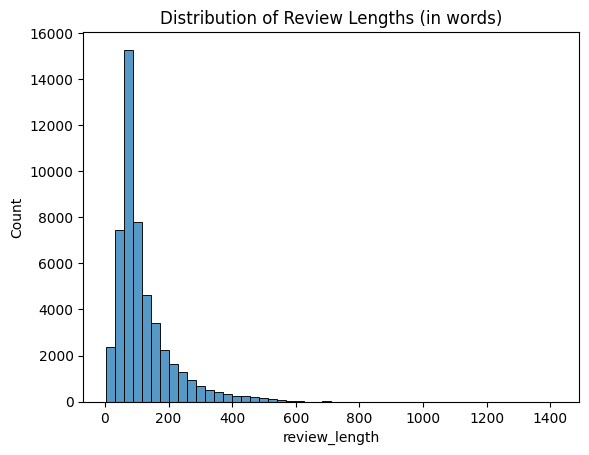

In [18]:

df['review_length'] = df['clean_review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=50)
plt.title("Distribution of Review Lengths (in words)")
plt.show()


## ☁️ WordClouds

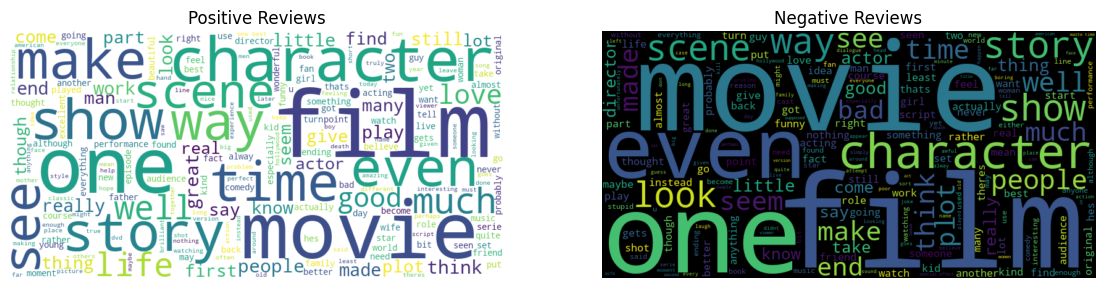

In [19]:

pos_text = " ".join(df[df['sentiment']==1]['clean_review'].tolist())
neg_text = " ".join(df[df['sentiment']==0]['clean_review'].tolist())

wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color="black").generate(neg_text)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews")
plt.show()


# **Key Insights from EDA**

1. The dataset is balanced (equal positive & negative reviews).  
2. Negative reviews are slightly shorter on average than positive ones.  
3. Frequent sentiment-specific words:  
   - Positive → *great, excellent, wonderful, best*.  
   - Negative → *bad, boring, worst, waste*.  
4. Phrases like *"worth watching"* vs *"waste of time"* drive sentiment strongly.  
5. POS analysis shows positive reviews use more **adjectives** and **superlatives**, negative reviews more **negations**.  
6. PCA shows clear (but not perfect) separability → indicates ML models can learn from this dataset.  
